## Building a Movie Rating Recommendation System
Recommender systems are an important class of machine learning algorithms that offer "relevant" suggestions to users. They can be categorized as either collaborative filtering or a content-based system. 

#### Collaborative Filtering Systems
Collaborative filtering methods for recommender systems are methods that are solely based on the past interactions between users and the target movies. Thus, the input to a collaborative filtering system will be all historical data of user interactions with target movies. This data is typically stored in a matrix where the rows are the users, and the columns are the movies.

The core idea behind such systems is that the historical data of the users should be enough to make a prediction. I.e we don’t need anything more than that historical data, no extra push from the user, no presently trending information, etc.

#### Content Based Filtering Systems

Content here refers to the content or attributes of the products you like. So, the idea in content-based filtering is to tag products using certain keywords, understand what the user likes, look up those keywords in the database and recommend different products with the same attributes.





### Business Problem

We need to build a Collaborative Filtering Systems based Recommender Systems that will predict the rating of a movie to the user based on the history of ratings of the user 

Suppose a user logs into an entertainment platform and wants to watch a movie, system need to suggest the movie rating based on the ratings the user has provided for other movies before and what rating other users who have watched similar movies have given to the current movie. The business reasons to do this are many. Few of the reasons are:

1. Relevancy - The rating for the movie must be relevant for the user, i.e. based on the user's past ratings and thereby interests, if the user has rated horror movies highly and romantic movies poorly in the past, then a similar relation must exist here also.

2. Retaining the customers - The entertainment platform must put in its best efforts to retain its customers. For example, if a user watches a movie rated highly and if the movie is indeed relvant to the user, the user may come back to the platform to watch more content.

In order to start our analysis, we import the 1 million dataset from movielens. They contain rating provided by 6040 users on 3706 movies.

In [99]:
import pandas as pd
import numpy as np
ratings = pd.read_csv('ratings.dat', sep = '::', engine='python', names=['userId','movieId','rating','timestamp'])

In [100]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [101]:
users = ratings['userId'].unique() #list of all users
movies = ratings['movieId'].unique() #list of all movies
print("Number of users", len(users))
print("Number of movies", len(movies))


Number of users 6040
Number of movies 3706


In [102]:
movies = pd.read_csv('movies.dat', sep = '::', engine='python',names=['movieId','movie_name','Genre'])
movies.head()

,movieId,movie_name,Genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


#### Missing Value Treatement

The machine learning models cannot work on null data or missing values. Hence we need to check whether there are any missing values and work on them

In [103]:
ratings.isnull().sum()/ratings.isnull().count()

userId       0.0
movieId      0.0
rating       0.0
timestamp    0.0
dtype: float64

In [104]:
movies.isnull().sum()/movies.isnull().count()

movieId       0.0
movie_name    0.0
Genre         0.0
dtype: float64

There are no missing values in both users and movies dataframe. And we can hence move on to the next step.

#### Exploratory Data Analysis


In [105]:
movies_data=pd.merge(ratings,movies, on='movieId')
movies_data.head()

,userId,movieId,rating,timestamp,movie_name,Genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama


In [106]:
ratings_mean_count=pd.DataFrame(movies_data.groupby('movie_name')['rating'].mean())
ratings_mean_count['ratings_count']=pd.DataFrame(movies_data.groupby('movie_name')['rating'].count())
ratings_mean_count.head()

,rating,ratings_count
movie_name,,
"$1,000,000 Duck (1971)",3.027027,37
'Night Mother (1986),3.371429,70
'Til There Was You (1997),2.692308,52
"'burbs, The (1989)",2.910891,303
...And Justice for All (1979),3.713568,199


As you can see from the above table, the average rating and ratings_count can give us an idea of how reliable the rating. For example,...And Justice for All (1979) movie has an average rating of 3.71 and around 199 users have rated this movie. This could suggest that this is a decent movie. 

Text(0.5, 0, 'Total movies individual users have rated')

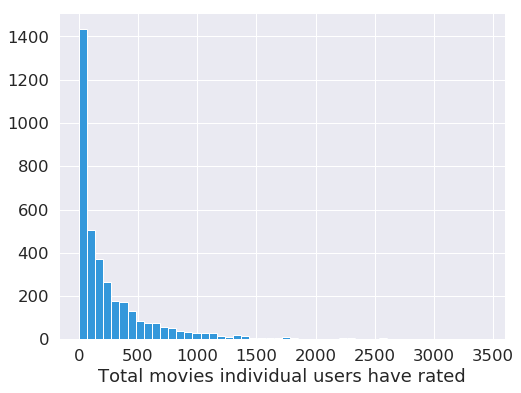

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['ratings_count'].hist(bins=50)
plt.xlabel('Total movies individual users have rated')

As you can see from the above chart, more than 25% of the users have rated less than 100 movies. And very few users have rated more than 1000 movies.

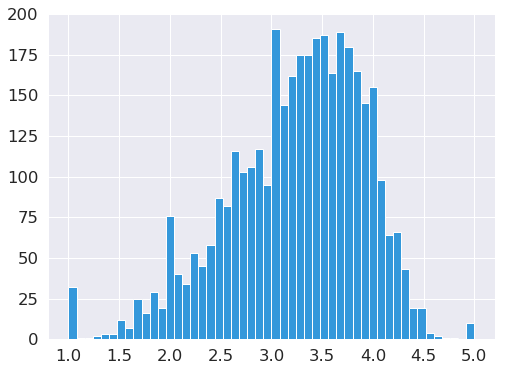

In [108]:
plt.figure(figsize=(8,6))
ratings_mean_count['rating'].hist(bins=50)

As you can see from the above plot, around 50% movies have been rated in the range 3-4. Very few movies are rated at around 5.

<Figure size 576x432 with 0 Axes>

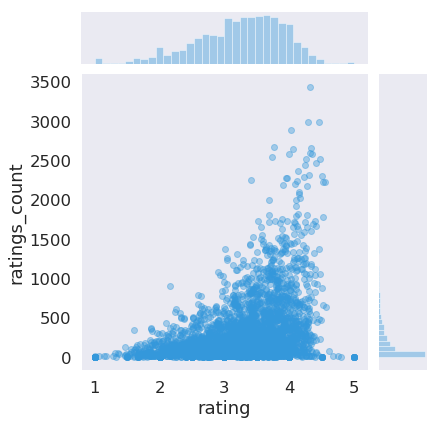

In [109]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='rating', y='ratings_count', data=ratings_mean_count, alpha=0.4)

As you can see from the above plot, movies that got a rating of 1 or 5 were rated by very few people. This makes sense because some individuals may have extreme views of some movies not many people have watched/rated. 

### Model Selection and Tuning

We now need to select a model for our data and tune the hyperparameters for the model to imrpove the performace of our model.

We select SVD model from the surprise package for the data since it is one of the best algorithms available for collborative filtering recommender systems.

In [78]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split



In [80]:
from surprise import Reader
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movies_data[['userId', 'movieId', 'rating']], reader)

In [81]:
train, testset = train_test_split(data, test_size=0.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(train)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8787


0.8786666108829045

After training and testing our algorithm for our data, we see that the accuracy of the algorithm is around 87.8%. This result inidcates that our model's prediction ability is good.

We can also consider a few more factors and methods to evaluate the model and improve the performance of our model.

#### Cross Validation
Cross Validation is performed in order to reduce the bias that may have happened when splitting the data between test set and training set. Cross validation divided the data into a specified number of sets, n (usually a default of 5 sets) and performs training on n-1 sets and uses 1 set as the test data to evaluate the performace of the model. This step is repeated till all the sets are used as test and train data. 

In [83]:
from surprise.model_selection import cross_validate
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8728  0.8736  0.8754  0.8736  0.8725  0.8736  0.0010  
MAE (testset)     0.6856  0.6859  0.6874  0.6857  0.6848  0.6859  0.0008  
Fit time          69.34   62.41   61.88   60.61   60.85   63.02   3.23    
Test time         8.86    4.89    1.92    4.05    2.99    4.54    2.38    


{'test_rmse': array([0.87276928, 0.87364936, 0.87541426, 0.87356267, 0.87252889]),
 'test_mae': array([0.68557096, 0.68594333, 0.68736839, 0.68569151, 0.68477638]),
 'fit_time': (69.34392976760864,
  62.41404414176941,
  61.88406205177307,
  60.605429887771606,
  60.854406118392944),
 'test_time': (8.864495992660522,
  4.890413999557495,
  1.922539234161377,
  4.050353050231934,
  2.990234851837158)}

According to the results seen above, RMSE score is around 87% which is very close to the results obtained during the model training and testing without cross validation.

#### GridSearchCV

Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyper parameter values specified.

The hyperparamters here are
1. n_epochs – The number of iteration of the Stochastic Gradient Descent(SGD) procedure. Default is 20
2. lr_all - The learning rate for all parameters. Default is 0.005
3. reg_all - The regularization term for all parameters. Default is 0.02

In [85]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

In [86]:
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9297929679010267
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


As you can see from the above results, the optimal values for our hyperparameters are:
1. n_epochs = 10
2. lr_all = 0.005
3. reg_all = 0.4

Using these values in our SVD algorithm, we need to check for the accuracy rate of our model again

In [90]:
algo1 = SVD(n_epochs= 10, lr_all= 0.005, reg_all =  0.4)
# Train the algorithm on the trainset, and predict ratings for the testset
algo1.fit(train)
predictions = algo1.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9305


0.9304576287240964

#### Inference:

As you can see from the above results, after finding the optimal paramters for the model using GridSearchCV, the performace of the model improved 600 basis points, which is very good.

### Model Accuracy Analysis

Prediction accuracy answers the question how well the recommender does at estimating preference

Decision support metrics answers how well the recommender does at finding good things

Rank accuracy metrics look at how well the recommender estimates relative preference

#### Metrics Families:
1. Fraction of Concordant Pair
2. Mean Absolute Error
3. Mean Squared Error
4. Root Mean Squared Error

#### Fraction of Concordant Pair
Looks at the fraction of all pairs that it puts in the correct order

In [92]:
from surprise.accuracy import fcp
print(fcp(predictions))

FCP:  0.7222
0.722228217128967


Hence according to this metrics it puts around 72.2% of the pairs in the correct order.

#### Mean Absolute Error

MAE=1|𝑅̂ * ∑ r𝑢𝑖∈𝑅̂ |𝑟𝑢𝑖−𝑟̂𝑢𝑖|

This gives us the abosulte mean error of predicted values and actual values.

In [94]:
from surprise.accuracy import mae
print(mae(predictions))

MAE:  0.7449
0.7448825486312489


Hence according to this metrics, its prediction accuracy is around 74.5%.

#### Mean Squared Error

MSE=1|𝑅̂ * ∑ r𝑢𝑖∈𝑅̂ |𝑟𝑢𝑖^2−𝑟̂𝑢𝑖^2|


In [95]:
from surprise.accuracy import mse
print(mse(predictions))

MSE: 0.8658
0.8657513988508685


Hence according to this metrics, its prediction accuracy is around 86.5%.

#### Root Mean Squared Error

RMSE=(1|𝑅̂ * ∑ r𝑢𝑖∈𝑅̂ |𝑟𝑢𝑖^2−𝑟̂𝑢𝑖^2|) ^ 0.5

If you observe the formula, this is the square root of the Mean sqaured error computed above


In [96]:
from surprise.accuracy import rmse
print(rmse(predictions))

RMSE: 0.9305
0.9304576287240964


This is indeed the square root of .865. The accuracy of this model is around 93%.

### Conclusion

We build a Collaborative Filtering based Reccommender System which has a very good accuracy of around 93%. Which will help the business retain customers and increase customer engagement in the entertainment platform.

There is definitely scope for improvement by taking more information about users and movies.

### Recommendation

When the user uses the imdb database for the first time, it is recommended that the system asks the user to rate a set of movies and this helps to prevent the cold start problem, wherein, we do not have enough information about the user preferences and hence recommendation becomes very difficult.